In [1]:
import numpy as np
import arepo
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from tqdm import tqdm
import matplotlib as mpl
from scipy.stats import binned_statistic_2d, binned_statistic
from numba import njit
import h5py as h5

import astropy.units as u

from joblib import Parallel, delayed

In [2]:
import illustris_python as il
TNGbase = '/n/holylfs05/LABS/hernquist_lab/IllustrisTNG/Runs/L35n2160TNG/output/'

In [3]:
GFM_SOLAR_METALLICITY = 0.0127

GFM_SOLAR_ABUNDANCE_HYDROGEN = 0.7388
GFM_SOLAR_ABUNDANCE_HELIUM  =  (1.-GFM_SOLAR_ABUNDANCE_HYDROGEN -GFM_SOLAR_METALLICITY)
GFM_SOLAR_ABUNDANCE_CARBON  =  0.0024
GFM_SOLAR_ABUNDANCE_NITROGEN =  0.0007
GFM_SOLAR_ABUNDANCE_OXYGEN  =  0.0057
GFM_SOLAR_ABUNDANCE_NEON    =  0.0012
GFM_SOLAR_ABUNDANCE_MAGNESIUM = 0.0007
GFM_SOLAR_ABUNDANCE_SILICON =  0.0007
GFM_SOLAR_ABUNDANCE_IRON   =   0.0013
GFM_SOLAR_ABUNDANCE_OTHER  =   0

HUBBLE = 3.2407789e-18
SEC_PER_MEGAYEAR = 3.15576e13

In [4]:
yield_path = '/n/holylfs05/LABS/hernquist_lab/IllustrisTNG/InitialConditions/Arepo_GFM_Tables_TNG/Yields/'

SNIa = h5.File(yield_path + 'SNIa.hdf5', mode='r')
SNII = h5.File(yield_path + 'SNII.hdf5', mode='r')

In [7]:
LifeTimes = h5.File(yield_path + 'Lifetimes.hdf5', mode='r')

In [10]:
print(LifeTimes['Masses'][:])
print(LifeTimes['Metallicities'][:])

[  0.6   0.7   0.8   0.9   1.    1.1   1.2   1.3   1.4   1.5   1.6   1.7
   1.8   1.9   2.    2.5   3.    4.    5.    6.    7.    9.   12.   15.
  20.   30.   40.   60.  100.  120. ]
[4.e-04 4.e-03 8.e-03 2.e-02 5.e-02 1.e+00]


In [17]:
LifeTimes['Masses'][22]

12.0

In [20]:
LifeTimes['Lifetimes'][1][22]/1e6

21.3957

In [72]:
print(SNII['Reference'][()])
print(SNIa['Reference'][()])

b'Portinari et al. 1998 (A&A, 334, 505)'
b'Thielemann et al. 2003 (From Twilight to Highlight: The Physics of SN proceedings, ESO/MPA/MPE Workshop, pg 331) - as tabulated in Travaglio et al. 2004 (A&A, 425, 1029)'


In [73]:
list(SNII.keys())

['Masses',
 'Metallicities',
 'Number_of_masses',
 'Number_of_metallicities',
 'Number_of_species',
 'Reference',
 'Species_names',
 'Yield_names',
 'Yields']

In [74]:
SNII['Metallicities'][:]

array([0.   , 0.001, 0.004, 0.02 ], dtype=float32)

In [18]:
SNII['Masses'][:]

array([  6.,   7.,   9.,  12.,  15.,  20.,  30.,  40.,  60., 100., 120.],
      dtype=float32)

In [75]:
SNII['Yields']['Z_0.001']['Ejected_mass'][:]

array([ 4.891062,  5.708756,  8.130853,  8.690539, 10.25411 , 12.445723,
       14.898044, 19.548176, 24.06858 , 31.77251 , 30.46581 , 51.589443,
       65.62609 ], dtype=float32)

In [76]:
list(SNII['Yields']['Z_0.001'].keys())

['Ejected_mass', 'Total_Metals', 'Yield']

In [77]:
SNII['Yields']['Z_0.001']['Total_Metals'][:] #/ SNII['Yields']['Z_0.0004']['Ejected_mass'][:]

array([ 0.13855194,  0.40709192,  1.3544728 ,  1.0117272 ,  0.8389207 ,
        1.181549  ,  4.0279903 ,  6.675713  ,  8.901664  , 12.460518  ,
        4.998241  , 11.149515  ,  4.7587585 ], dtype=float32)

In [79]:
SNII['Yields']['Z_0.001']['Yield'][10]

array([-0.00097343,  0.07432161,  0.07400328,  0.03253458,  0.03117942,
        0.03129362,  0.03064575,  0.02973319,  0.02944528,  0.03140595,
       -0.00285885, -0.00498329, -0.00506879], dtype=float32)

In [80]:
for i in range(len(SNII['Species_names'][:])):
    print(i, SNII['Species_names'][i])

0 b'Hydrogen'
1 b'Helium'
2 b'Carbon'
3 b'Nitrogen'
4 b'Oxygen'
5 b'Neon'
6 b'Magnesium'
7 b'Silicon'
8 b'Sulphur'
9 b'Calcium'
10 b'Iron'


[  8.   9.  12.  13.  15.  18.  20.  25.  30.  40.  60. 100. 120.]


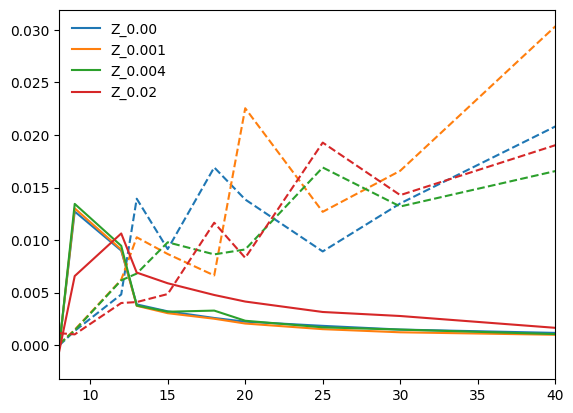

In [109]:
mass = SNII['Masses'][:]
print(mass)
for Z in SNII['Yields'].keys():
    m_ej = SNII['Yields'][Z]['Ejected_mass'][:]
    m_Mg = SNII['Yields'][Z]['Yield'][6]
    m_Fe = SNII['Yields'][Z]['Yield'][10]

    # m_Fe[m_Fe < 0] = 0

    l = plt.plot(mass, m_Fe/m_ej, label=Z)
    plt.plot(mass, m_Mg/m_ej, c=l[0].get_color(), ls='dashed')
    
    plt.legend(frameon=False)
    
    plt.xlim(8, 40)

[  8.   9.  12.  13.  15.  18.  20.  25.  30.  40.  60. 100. 120.]


/tmp/ipykernel_3519772/1452405976.py:11: RuntimeWarning: invalid value encountered in log10
  plt.plot(mass, np.log10(m_Mg/m_Fe/MgFe_solar), label=Z)


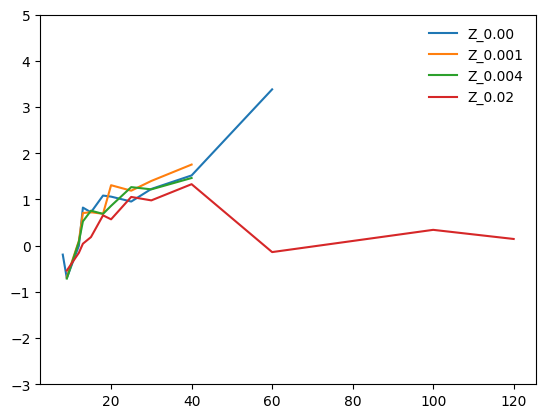

In [119]:
mass = SNII['Masses'][:]
print(mass)
for Z in SNII['Yields'].keys():
    m_ej = SNII['Yields'][Z]['Ejected_mass'][:]
    m_Mg = SNII['Yields'][Z]['Yield'][6]
    m_Fe = SNII['Yields'][Z]['Yield'][10]

    # m_Fe[m_Fe < 0] = 0

    MgFe_solar = GFM_SOLAR_ABUNDANCE_MAGNESIUM/GFM_SOLAR_ABUNDANCE_IRON
    plt.plot(mass, np.log10(m_Mg/m_Fe/MgFe_solar), label=Z)
    # l = plt.plot(mass, m_Fe/m_ej, label=Z)
    # plt.plot(mass, m_Mg/m_ej, c=l[0].get_color(), ls='dashed')
    
    plt.legend(frameon=False)
    
    # plt.xlim(8, 40)
    plt.ylim(-3, 5)

In [103]:
print(SNIa['Total_Metals'][()])
print(np.sum(SNIa['Yield']))

1.3740858
1.3743416


In [104]:
for i in range(len(SNIa['Species_names'][:])):
    print(i, SNIa['Species_names'][i], SNIa['Yield'][i]/SNIa['Total_Metals'][()])

0 b'Hydrogen' 0.0
1 b'Helium' 0.0
2 b'Lithium' 0.0
3 b'Beryllium' 0.0
4 b'Boron' 0.0
5 b'Carbon' 0.035151664
6 b'Nitrogen' 8.451583e-07
7 b'Oxygen' 0.10406922
8 b'Fluorine' 4.12638e-10
9 b'Neon' 0.0032883391
10 b'Sodium' 4.5994217e-05
11 b'Magnesium' 0.0062385486
12 b'Aluminum' 0.00071756804
13 b'Silicon' 0.11105639
14 b'Phosphorus' 0.00030420226
15 b'Sulphur' 0.06291479
16 b'Chlorine' 0.0001264841
17 b'Argon' 0.011615003
18 b'Potassium' 6.741937e-05
19 b'Calcium' 0.008983548
20 b'Scandium' 1.7975589e-07
21 b'Titanium' 0.0001820876
22 b'Vanadium' 3.748549e-05
23 b'Chromium' 0.0046547316
24 b'Manganese' 0.0059894365
25 b'Iron' 0.5410601
26 b'Cobalt' 0.0007423117
27 b'Nickel' 0.102913745
28 b'Copper' 1.7997421e-06
29 b'Zinc' 2.4324245e-05
30 b'Gallium' 0.0
31 b'Germanium' 0.0
32 b'Arsenic' 0.0
33 b'Selenium' 0.0
34 b'Bromine' 0.0
35 b'Krypton' 0.0
36 b'Rubidium' 0.0
37 b'Strontium' 0.0
38 b'Yttrium' 0.0
39 b'Zirconium' 0.0
40 b'Niobium' 0.0
41 b'Molybdenum' 0.0
